# <span style="color:red"> Multiasset test: Pricing Geometric Average Basket Option </span>

In [1]:
import numpy as np
from pricing import EquityForwardCurve, DiscountingCurve, ForwardVariance, Black, Vanilla_PayOff
from montecarlo import MC, MC_Analisys
import lets_be_rational.LetsBeRational as lbr
from scipy import exp, log, sqrt
import matplotlib.pyplot as plt
from closedforms import GAM_Basket_option_closed_form, volatility_basket, forward_basket
from scipy.stats.mstats import gmean
from numpy.linalg import cholesky
import scipy.stats as si  #for gaussian cdf
import time, sys
import matplotlib.ticker as mticker

### Parameters of the Simulation

In [2]:
r = 1./100
t = 0
spot_price = np.array([110,120,97,133])
T_max = 10
N_simulation = 2e5
volatility = np.array([20.,30.,25.,32.])/100
corr = np.array(([1,0.15,0.10,0.20],[0.15,1.,-0.05,0.18],[0.1,-0.05,1.,0.13],[0.20,0.18,0.13,1]))
N_equity = len(corr)

### Market Data

In [3]:
"""Discounut Factors"""
zero_interest_rate = np.array([r,r,r])
zero_interest_rate_dates = np.array([0.01,5,T_max])
d = exp(-zero_interest_rate*zero_interest_rate_dates)        #market discount factors 
D = DiscountingCurve(reference=t, discounts=d, dates=zero_interest_rate_dates)   #discounting curve

Forward interest rate time grid [ 0.01  5.   10.  ]
Forward interest rate:  [0.01 0.01 0.01]


In [4]:
F = []   #list of all equity forward curves
for i in range(N_equity):
    F.append(EquityForwardCurve(reference=t,spot=spot_price[i],discounting_curve=D,repo_rates=np.array([0,0]),repo_dates=np.array([0,T_max])))

Forward repo time grid [ 0 10]
Forward repo rate:  [0. 0.]
Forward repo time grid [ 0 10]
Forward repo rate:  [0. 0.]
Forward repo time grid [ 0 10]
Forward repo rate:  [0. 0.]
Forward repo time grid [ 0 10]
Forward repo rate:  [0. 0.]


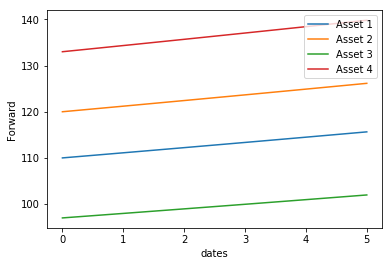

In [5]:
x = np.linspace(0,5,100)
for i in range(len(F)):
    plt.plot(x,F[i](x),label="Asset "+str(i+1))

plt.legend()
plt.xlabel("dates")
plt.ylabel("Forward")
plt.show()

In [6]:
T1 = np.array([0.08,0.17,0.25,0.33,0.42,0.50,1.0,2.0,T_max])
K1 = np.array([spot_price[0],164,172,180])

sigma1 = np.array(([volatility[0],volatility[0],volatility[0],volatility[0],volatility[0],volatility[0],volatility[0],volatility[0],volatility[0]],[32,29.1,28.9,29.3,29.4,29.4,29.6,30.6,30.63],[33.6,29.3,29,29.3,29.3,29.3,29.3,30.6,30.59],[35,29.7,29.4,29.5,29.4,29.3,29.3,30.5,30.46]))
sigma1 = sigma1

T2 = np.array([0.08,0.17,0.25,0.33,0.42,0.50,1.0,2.0,T_max])
K2 = np.array([spot_price[1],164,172,180])
sigma2 = np.array(([volatility[1],volatility[1],volatility[1],volatility[1],volatility[1],volatility[1],volatility[1],volatility[1],volatility[1]],[32,29.1,28.9,29.3,29.4,29.4,29.6,30.6,30.63],[33.6,29.3,29,29.3,29.3,29.3,29.3,30.6,30.59],[35,29.7,29.4,29.5,29.4,29.3,29.3,30.5,30.46]))
sigma2 = sigma2

T3 = np.array([0.08,0.17,0.25,0.33,0.42,0.50,1.0,2.0,T_max])
K3 = np.array([spot_price[2],164,172,180])
sigma3 = np.array(([volatility[2],volatility[2],volatility[2],volatility[2],volatility[2],volatility[2],volatility[2],volatility[2],volatility[2]],[32,29.1,28.9,29.3,29.4,29.4,29.6,30.6,30.63],[33.6,29.3,29,29.3,29.3,29.3,29.3,30.6,30.59],[35,29.7,29.4,29.5,29.4,29.3,29.3,30.5,30.46]))


T4 = np.array([0.08,0.17,0.25,0.33,0.42,0.50,1.0,2.0,T_max])
K4 = np.array([spot_price[3],164,172,180])
sigma4 = np.array(([volatility[3],volatility[3],volatility[3],volatility[3],volatility[3],volatility[3],volatility[3],volatility[3],volatility[3]],[32,29.1,28.9,29.3,29.4,29.4,29.6,30.6,30.63],[33.6,29.3,29,29.3,29.3,29.3,29.3,30.6,30.59],[35,29.7,29.4,29.5,29.4,29.3,29.3,30.5,30.46]))

V = []  #list of variances

V.append(ForwardVariance(reference=0,maturities=T1,strikes=K1,spot_volatility=sigma1,strike_interp=spot_price[0]))
V.append(ForwardVariance(reference=0,maturities=T2,strikes=K2,spot_volatility=sigma2,strike_interp=spot_price[1]))
V.append(ForwardVariance(reference=0,maturities=T3,strikes=K3,spot_volatility=sigma3,strike_interp=spot_price[2]))
V.append(ForwardVariance(reference=0,maturities=T4,strikes=K4,spot_volatility=sigma4,strike_interp=spot_price[3]))

Forward volatility time grid:  [ 0.08  0.17  0.25  0.33  0.42  0.5   1.    2.   10.  ]
Forward volatility:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Forward volatility time grid:  [ 0.08  0.17  0.25  0.33  0.42  0.5   1.    2.   10.  ]
Forward volatility:  [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]
Forward volatility time grid:  [ 0.08  0.17  0.25  0.33  0.42  0.5   1.    2.   10.  ]
Forward volatility:  [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
Forward volatility time grid:  [ 0.08  0.17  0.25  0.33  0.42  0.5   1.    2.   10.  ]
Forward volatility:  [0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32]


### Simulation

In [7]:
model = Black(forward_curve=F, variance=V)
maturities = np.arange(1,31)*0.15
ATM = gmean(spot_price)
print("ATM:", ATM)
S_t = model.simulate(Nsim=N_simulation,corr=corr,Ndim = N_equity, seed=10,fixings=maturities)
G_mean = gmean(S_t, axis=2)

ATM: 114.23503697769888
Multi Asset Simulation


### Convergence Check

In [8]:
kind = 1
payoff = Vanilla_PayOff(St=G_mean, strike=ATM,typo=kind)
x, mean, err = MC_Analisys(payoff,100)
call_black = GAM_Basket_option_closed_form(forward = F, strike= ATM, maturity=maturities, reference=t, zero_interest_rate = r, volatility=volatility, correlation=corr, typo = kind)

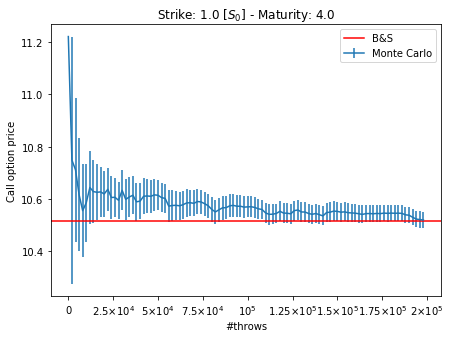

In [9]:
n = 26

mean_price = (mean*D(maturities)).T[n]
err_price = (err*D(maturities)).T[n]

plt.figure(figsize=(7,5))
plt.errorbar(x,mean_price,yerr=err_price,label = 'Monte Carlo')
plt.axhline(y=call_black[n], color = 'red',linestyle='-',label = 'B&S')
plt.xlabel("#throws")
plt.title("Strike: "+str(ATM/ATM)+" [$S_0$] - Maturity: "+str(round(maturities[n],1)))
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
    #plt.savefig('Graphs/European_call_option.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    #plt.savefig('Graphs/European_put_option.pdf')
plt.show()

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


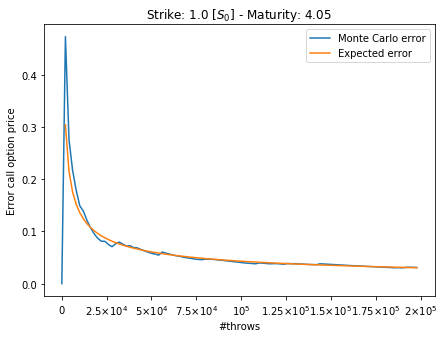

In [10]:
z = np.std(payoff.T[n])
y = np.sqrt(x)
plt.figure(figsize=(7,5))
plt.plot(x,err_price, label = 'Monte Carlo error')
plt.plot(x,z/y, label = 'Expected error')
plt.xlabel("#throws")
plt.title("Strike: "+str(ATM/ATM)+" [$S_0$] - Maturity: "+str(round(maturities[n],2)))
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.legend()
if kind==1:
    plt.ylabel('Error call option price')
   # plt.savefig('Graphs/Error_euro_call_option.pdf')
elif kind==-1:
    plt.ylabel('Error put option price')
    #plt.savefig('Graphs/Error_euro_put_option.pdf')

plt.show()

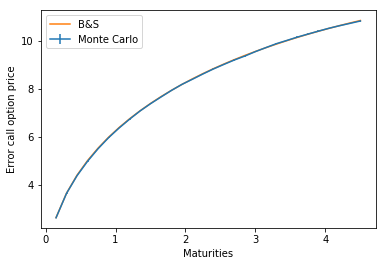

In [47]:
result,result_err = MC(payoff)*D(maturities)
plt.errorbar(maturities,result,result_err,label="Monte Carlo")
plt.plot(maturities,call_black,label="B&S")
plt.legend()
plt.xlabel("Maturities")
if kind==1:
    plt.ylabel('Error call option price')
elif kind==-1:
    plt.ylabel('Error put option price')

plt.show()

### Implied volatility in function of Log-moneyness log(K/F)

In [49]:
logmoneyness =np.arange(-10,11)*0.1
imp_volatility = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_plus = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_minus = np.zeros((len(logmoneyness),len(maturities)))
f = forward_basket(forward=F, volatility=volatility, correlation=corr, maturity=maturities, reference=t)
X_t = G_mean/f
E_X = np.mean(X_t,axis=0)
start_time = time.time()
for i in range(len(logmoneyness)):
    if i%10 == 0:
        print("Running: ",i,"%")
    if logmoneyness[i]>=0.:
        kind =1
    elif logmoneyness[i]<0.:
        kind =-1
    K = exp(logmoneyness[i])
    option = Vanilla_PayOff(St=X_t, strike=K,typo=kind)
    result, err_result = MC(option)
    for j in range(len(maturities)):
        imp_volatility[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j],E_X[j],K,maturities[j],kind)
        imp_volatility_plus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]+err_result[j],E_X[j],K,maturities[j],kind)
        imp_volatility_minus[i][j] = lbr.implied_volatility_from_a_transformed_rational_guess(result[j]-err_result[j],E_X[j],K,maturities[j],kind)
        
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))
print("Saving_Files...")
print("COMPLETED")

Running:  0 %
Running:  10 %
Running:  20 %
Execution time: ---0.3191444993019104 min ---
Saving_Files...
COMPLETED


In [50]:
y_lower = np.zeros((len(logmoneyness),len(maturities)))
y_upper = np.zeros((len(logmoneyness),len(maturities)))
sigma_basket = vol_basket(volatility,corr)
for i in range(len(logmoneyness)):
     for j in range(len(maturities)):
            if(imp_volatility_minus[i][j]<imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_minus[i][j])
                y_upper[i][j] = abs(imp_volatility_plus[i][j]-imp_volatility[i][j])
            elif(imp_volatility_minus[i][j]>imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i][j])
                y_upper[i][j] = abs(imp_volatility_minus[i][j]-imp_volatility[i][j])

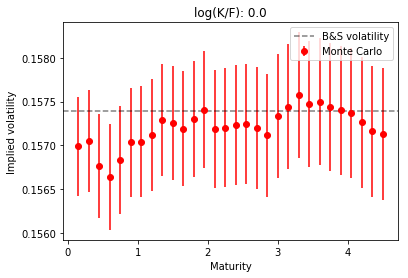

In [51]:
"""Fixed Strike"""  #ATM = 5
num = [10]    # 0, 5, 15
c=2
for i in range(len(num)):
    err_lower = 2*y_lower[num[i]]
    err_upper = 2*y_upper[num[i]]
    plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "red",label="Monte Carlo")
    plt.title("log(K/F): "+str(round(logmoneyness[num[i]],c)))

plt.axhline(y=sigma_basket, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity")
plt.ylabel("Implied volatility")
plt.legend()
plt.show()

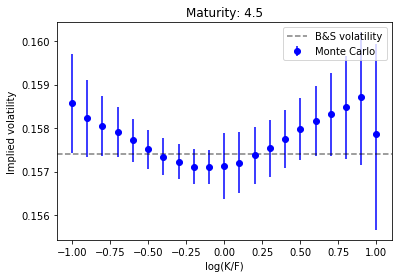

In [52]:
"""Fixed Maturity"""
num = [29]  #0, 6, 39
c=1
for i in range(len(num)):
    err_lower = 2*y_lower.T[num[i]]
    err_upper = 2*y_upper.T[num[i]]
    plt.errorbar(logmoneyness,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="blue",label="Monte Carlo")
plt.axhline(y=sigma_basket, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("log(K/F)")
plt.ylabel("Implied volatility")
plt.title("Maturity: "+str(round(maturities[num[i]],c)))
#plt.ylim(0.195,0.202) #0
#plt.ylim(0.07,0.215) #6
plt.legend()
plt.show()